<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running outside of colab
Running as a notebook


<h2>Imports etc</h2>

In [2]:
# import sys
# sys.path.append("../..")
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [11]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=ioi\
--zero-ablation\
--threshold=0.71\
--indices-mode=reverse\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

In [12]:
TASK

'ioi'

<h2>Setup Task</h2>

In [13]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


/datadrive/madhur/Automatic-Circuit-Discovery/acdc/ioi/ioi_dataset.py:514: UserWarning:

S2 index has been computed as the same for S and S2



<p> Let's define the four most important objects for ACDC experiments:

In [14]:

validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

<h2>Setup ACDC Experiment</h2>

In [15]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 32923
New metric: -1.9823053420964243e-08

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.hook_mlp_out [:] is 0.09469714015722275 (and current metric -1.9823053420964243e-08)
Result is 0.09469715998027617...so removing connection
No edge 32922

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 0] is 1.538834810256958 (and current metric 0.09469714015722275)
Result is 1.4441376700997353...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.11.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))

Metric after removing connection to blocks.11.attn.hook_result [:, :, 1] is 0.09291382879018784 (and current metric 0.09469714015722275)
Res

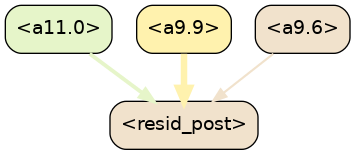

0 --------------------------------------------------
No edge 32613
32613
No edge 32613
New metric: 2.355602741241455
No edge 32613
No edge 32613
No edge 32613
We moved to  blocks.11.attn.hook_v[:, :, 11]
No edge 32613
No edge 32612
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 10]
No edge 32612
No edge 32611
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 9]
No edge 32611
No edge 32610
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 8]
No edge 32610
No edge 32609
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 7]
No edge 32609
No edge 32608
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 6]
No edge 32608
No edge 32607
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 5]
No edge 32607
No edge 32606
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 4]
No edge 32606
No edge 32605
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 3]
No edge 32605
No edge 32604
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 2]
No edge 32604
No edge 32603
Bu

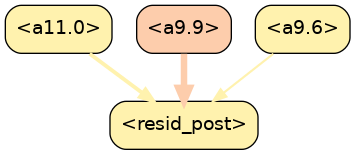

1 --------------------------------------------------
No edge 32602
32602
No edge 32602
New metric: 2.355602741241455

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.11.hook_v_input [:, :, 0] is 2.9856016635894775 (and current metric 2.355602741241455)
Result is 0.6299989223480225...so removing connection
No edge 32601
We moved to  blocks.11.attn.hook_k[:, :, 11]
No edge 32601
No edge 32600
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 10]
No edge 32600
No edge 32599
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 9]
No edge 32599
No edge 32598
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 8]
No edge 32598
No edge 32597
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 7]
No edge 32597
No edge 32596
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 6]
No edge 32596
No edge 32595
But it's bad
We moved to  blocks.11.attn.hoo

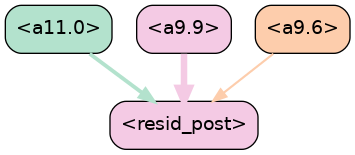

2 --------------------------------------------------
No edge 32590
32590
No edge 32590
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.11.hook_k_input [:, :, 0] is 2.9856016635894775 (and current metric 2.9856016635894775)
Result is 0.0...so removing connection
No edge 32589
We moved to  blocks.11.attn.hook_q[:, :, 11]
No edge 32589
No edge 32588
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 10]
No edge 32588
No edge 32587
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 9]
No edge 32587
No edge 32586
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 8]
No edge 32586
No edge 32585
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 7]
No edge 32585
No edge 32584
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 6]
No edge 32584
No edge 32583
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 5]


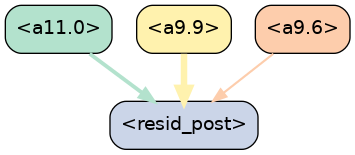

3 --------------------------------------------------
No edge 32578
32578
No edge 32578
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.11.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.11.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.11.hook_q_input [:, :, 0] is 2.9856016635894775 (and current metric 2.9856016635894775)
Result is 0.0...so removing connection
No edge 32577
We moved to  blocks.11.hook_v_input[:, :, 11]
No edge 32577
No edge 32433
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 10]
No edge 32433
No edge 32289
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 9]
No edge 32289
No edge 32145
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 8]
No edge 32145
No edge 32001
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 7]
No edge 32001
No edge 31857
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 6]
No edge 31857
No edge 31713
But it's bad
We moved to  blocks.11.hook_v_input[:,

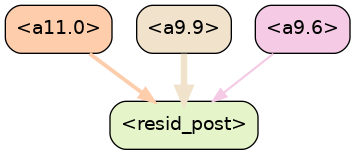

4 --------------------------------------------------
No edge 22368
22368
No edge 22368
New metric: 2.9856016635894775
No edge 22368
No edge 22368
No edge 22368
We moved to  blocks.9.attn.hook_result[:, :, 8]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 7]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 6]
No edge 22368


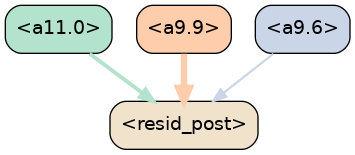

5 --------------------------------------------------
No edge 22368
22368
No edge 22368
New metric: 2.9856016635894775
No edge 22368
No edge 22368
No edge 22368
We moved to  blocks.9.attn.hook_result[:, :, 5]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 4]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 3]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 2]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 1]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_result[:, :, 0]
No edge 22368
No edge 22368
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 11]
No edge 22368
No edge 22367
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 10]
No edge 22367
No edge 22366
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 9]
No edge 22366


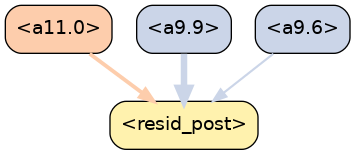

6 --------------------------------------------------
No edge 22366
22366
No edge 22366
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 9]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_v, [:, :, 9]))

Metric after removing connection to blocks.9.hook_v_input [:, :, 9] is 6.416523456573486 (and current metric 2.9856016635894775)
Result is 3.430921792984009...so keeping connection
No edge 22366
We moved to  blocks.9.attn.hook_v[:, :, 8]
No edge 22366
No edge 22365
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 7]
No edge 22365
No edge 22364
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 6]
No edge 22364


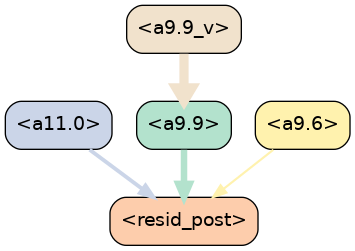

7 --------------------------------------------------
No edge 22364
22364
No edge 22364
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_v, [:, :, 6]))

Metric after removing connection to blocks.9.hook_v_input [:, :, 6] is 4.759042739868164 (and current metric 2.9856016635894775)
Result is 1.7734410762786865...so keeping connection
No edge 22364
We moved to  blocks.9.attn.hook_v[:, :, 5]
No edge 22364
No edge 22363
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 4]
No edge 22363
No edge 22362
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 3]
No edge 22362
No edge 22361
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 2]
No edge 22361
No edge 22360
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 1]
No edge 22360
No edge 22359
But it's bad
We moved to  blocks.9.attn.hook_v[:, :, 0]
No edge 22359
No edge 22358
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 11

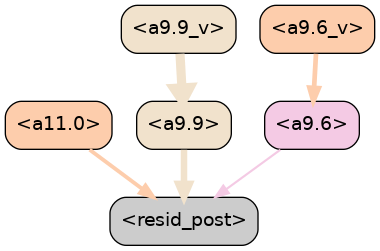

8 --------------------------------------------------
No edge 22356
22356
No edge 22356
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 9]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_k, [:, :, 9]))

Metric after removing connection to blocks.9.hook_k_input [:, :, 9] is 5.9402756690979 (and current metric 2.9856016635894775)
Result is 2.954674005508423...so keeping connection
No edge 22356
We moved to  blocks.9.attn.hook_k[:, :, 8]
No edge 22356
No edge 22355
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 7]
No edge 22355
No edge 22354
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 6]
No edge 22354


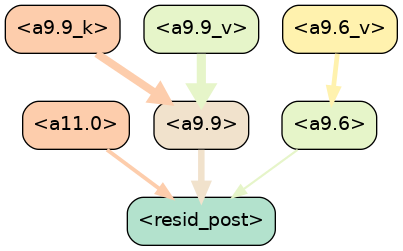

9 --------------------------------------------------
No edge 22354
22354
No edge 22354
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_k, [:, :, 6]))

Metric after removing connection to blocks.9.hook_k_input [:, :, 6] is 4.6697187423706055 (and current metric 2.9856016635894775)
Result is 1.684117078781128...so keeping connection
No edge 22354
We moved to  blocks.9.attn.hook_k[:, :, 5]
No edge 22354
No edge 22353
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 4]
No edge 22353
No edge 22352
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 3]
No edge 22352
No edge 22351
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 2]
No edge 22351
No edge 22350
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 1]
No edge 22350
No edge 22349
But it's bad
We moved to  blocks.9.attn.hook_k[:, :, 0]
No edge 22349
No edge 22348
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 11

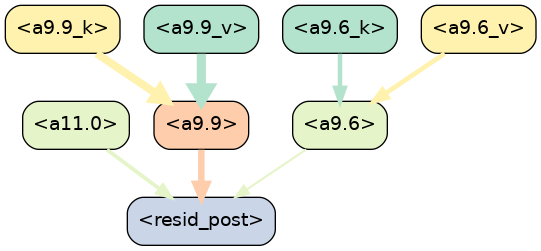

10 --------------------------------------------------
No edge 22346
22346
No edge 22346
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 9]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_q, [:, :, 9]))

Metric after removing connection to blocks.9.hook_q_input [:, :, 9] is 6.33278751373291 (and current metric 2.9856016635894775)
Result is 3.3471858501434326...so keeping connection
No edge 22346
We moved to  blocks.9.attn.hook_q[:, :, 8]
No edge 22346
No edge 22345
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 7]
No edge 22345
No edge 22344
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 6]
No edge 22344


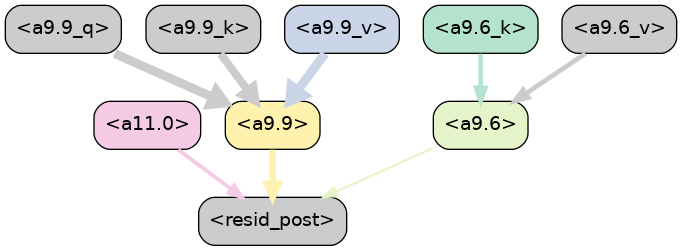

11 --------------------------------------------------
No edge 22344
22344
No edge 22344
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.9.attn.hook_q, [:, :, 6]))

Metric after removing connection to blocks.9.hook_q_input [:, :, 6] is 4.732725620269775 (and current metric 2.9856016635894775)
Result is 1.7471239566802979...so keeping connection
No edge 22344
We moved to  blocks.9.attn.hook_q[:, :, 5]
No edge 22344
No edge 22343
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 4]
No edge 22343
No edge 22342
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 3]
No edge 22342
No edge 22341
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 2]
No edge 22341
No edge 22340
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 1]
No edge 22340
No edge 22339
But it's bad
We moved to  blocks.9.attn.hook_q[:, :, 0]
No edge 22339
No edge 22338
But it's bad
We moved to  blocks.9.hook_v_input[:, :, 

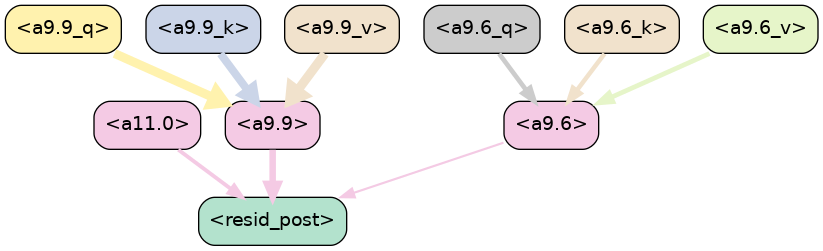

12 --------------------------------------------------
No edge 22102
22102
No edge 22102
New metric: 2.9856016635894775

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 9]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 2.784308433532715 (and current metric 2.9856016635894775)
Result is -0.2012932300567627...so removing connection
No edge 22101

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 2.7250425815582275 (and current metric 2.784308433532715)
Result is -0.059265851974487305...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is

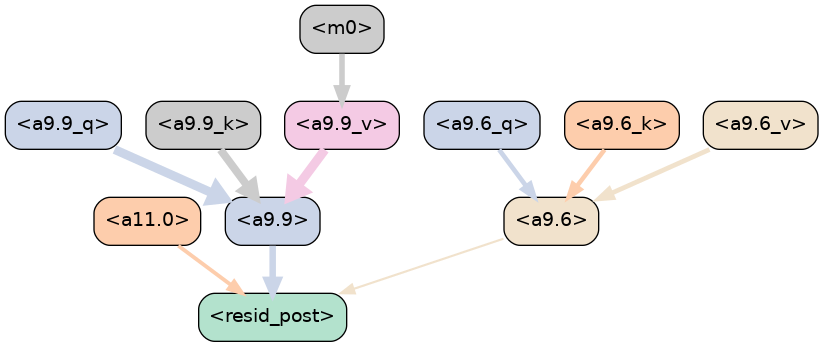

13 --------------------------------------------------
No edge 21749
21749
No edge 21749
New metric: 3.247188091278076

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 3.094923973083496 (and current metric 3.247188091278076)
Result is -0.15226411819458008...so removing connection
No edge 21748

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 3.0524871349334717 (and current metric 3.094923973083496)
Result is -0.042436838150024414...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 

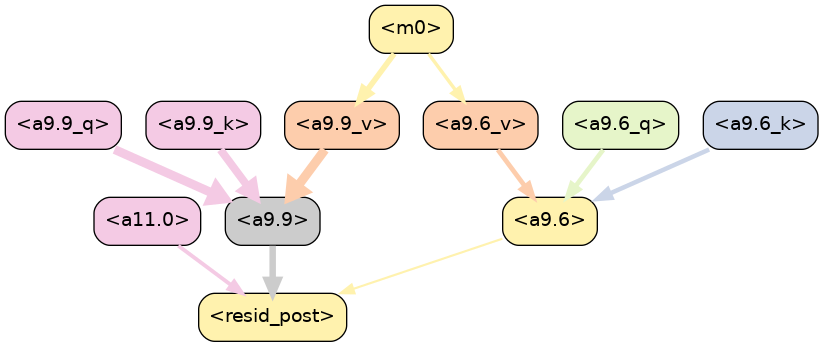

14 --------------------------------------------------
No edge 20688
20688
No edge 20688
New metric: 3.258103847503662

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 9]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 3.305202007293701 (and current metric 3.258103847503662)
Result is 0.04709815979003906...so removing connection
No edge 20687

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 3.2212138175964355 (and current metric 3.305202007293701)
Result is -0.08398818969726562...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 3.

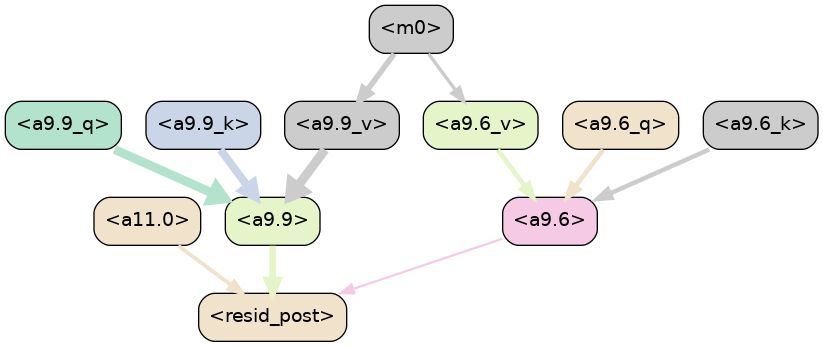

15 --------------------------------------------------
No edge 20334
20334
No edge 20334
New metric: 6.0377421379089355

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 6.048698425292969 (and current metric 6.0377421379089355)
Result is 0.010956287384033203...so removing connection
No edge 20333

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 5.994451999664307 (and current metric 6.048698425292969)
Result is -0.05424642562866211...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_k_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 

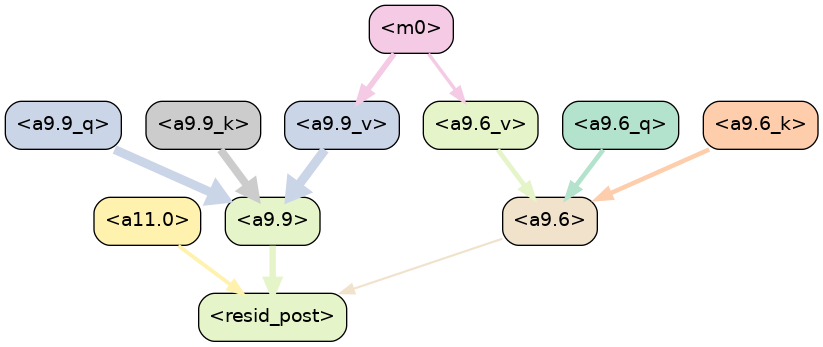

16 --------------------------------------------------
No edge 19272
19272
No edge 19272
New metric: 7.765726566314697

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 9]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 7.765726566314697 (and current metric 7.765726566314697)
Result is 0.0...so removing connection
No edge 19271

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 7.765726566314697 (and current metric 7.765726566314697)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 9]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 7.765726566314697 (and current metri

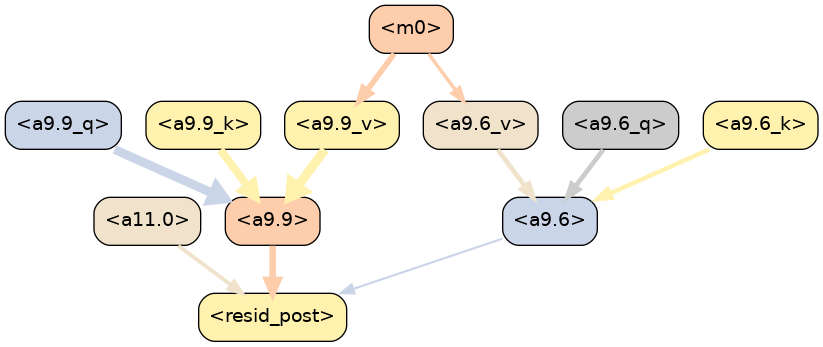

17 --------------------------------------------------
No edge 18918
18918
No edge 18918
New metric: 7.765726566314697

Node: cur_parent=TLACDCInterpNode(blocks.8.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.8.hook_mlp_out [:] is 7.765726566314697 (and current metric 7.765726566314697)
Result is 0.0...so removing connection
No edge 18917

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 0] is 7.765726566314697 (and current metric 7.765726566314697)
Result is 0.0...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.8.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.9.hook_q_input, [:, :, 6]))

Metric after removing connection to blocks.8.attn.hook_result [:, :, 1] is 7.765726566314697 (and current metri

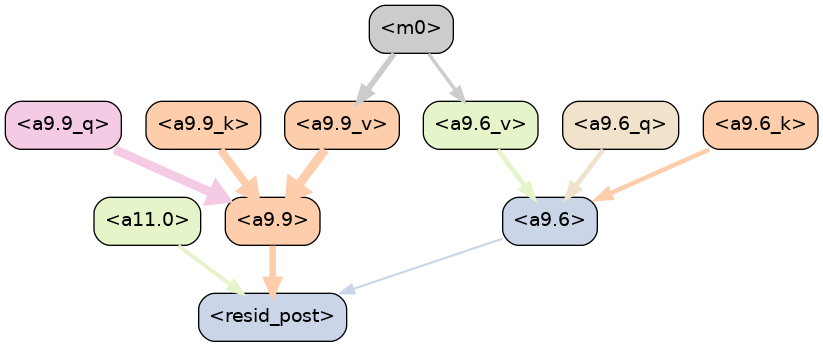

18 --------------------------------------------------
No edge 96
96
No edge 96
New metric: 7.765726566314697
No edge 96
We moved to  blocks.0.hook_mlp_in[:]
No edge 96


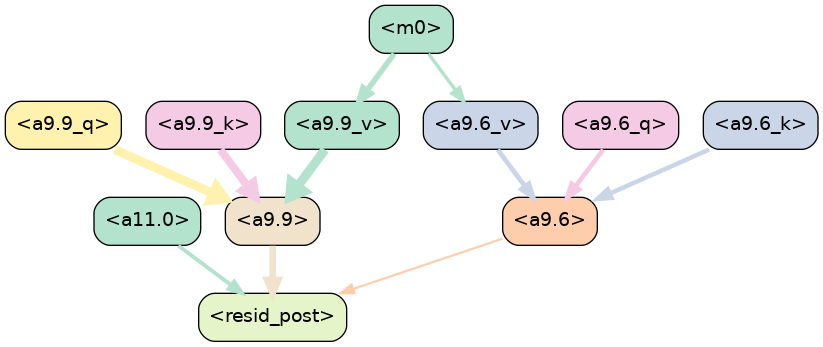

19 --------------------------------------------------
No edge 96
96
No edge 96
New metric: 7.765726566314697

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 0] is 7.732635498046875 (and current metric 7.765726566314697)
Result is -0.033091068267822266...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 1] is 7.776368141174316 (and current metric 7.732635498046875)
Result is 0.043732643127441406...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.0.attn.hook_result, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.0.hook_mlp_in, [:]))

Metric after removing connection to blocks.0.attn.hook_result [:, :, 2] is 7.74691915512085 (and cur

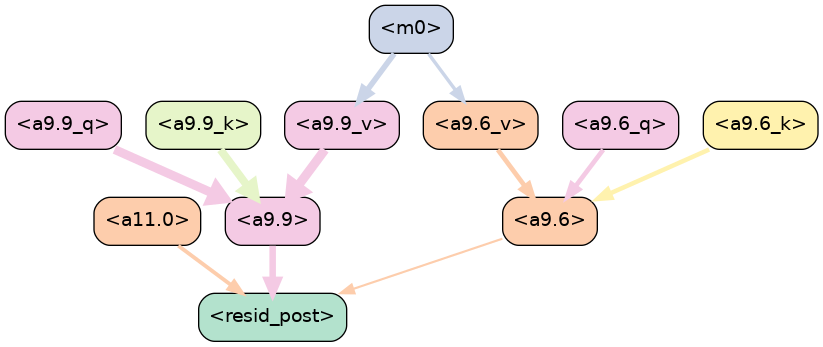

20 --------------------------------------------------
No edge 11
11
No edge 11
New metric: 8.135351181030273
We moved to  None
No edge 11


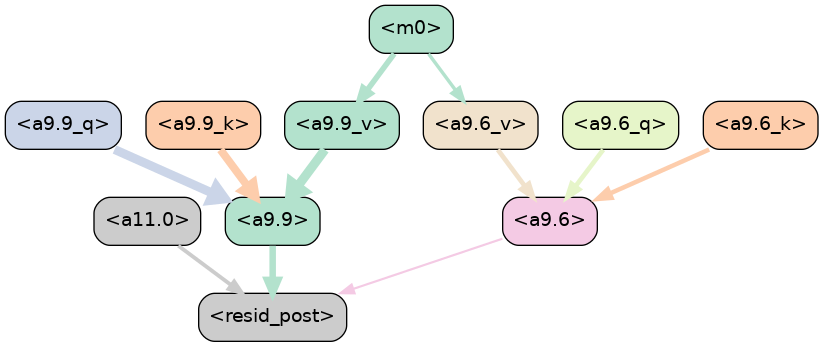

21 --------------------------------------------------
No edge 11
11


In [16]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [9]:
exp.save_subgraph(
    return_it=True,
)

OrderedDict([(('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 6)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.0.hook_resid_pre',
               (None,)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_q',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_k',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_v',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_q',
               (None, None, 6),
               'blocks.1.hook_q_input',
               (None, None, 6)),
              True),
        